## Goal:
Classify Positive/Negative Sentiment from comments in Ruby Rivlin Facebook Page.

In [1]:
import numpy as np 
import pandas as pd 
import re  
import nltk 
import codecs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import csv
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google_trans_new import google_translator  
nltk.download('stopwords')  
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import naive_bayes, svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import operator
from wordcloud import WordCloud
from bidi.algorithm import get_display
import json
from sklearn.preprocessing import scale
from operator import itemgetter
#import eli5
from treeinterpreter import treeinterpreter as ti
import shap
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load data files

In [2]:
#token - Original data
token_train = pd.read_csv("data/token_train.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)
token_test = pd.read_csv("data/token_test.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)

#morph - Data after morphologic processing
morph_train = pd.read_csv("data/morph_train.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)
morph_test = pd.read_csv("data/morph_test.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)

#token_eng - Data after english translation (using google translate)
token_train_eng = pd.read_csv("data/token_train_english.csv", header=None)
token_test_eng = pd.read_csv("data/token_test_english.csv", header=None)

In [3]:
print(token_train.shape)
print(morph_train.shape)
print(token_train_eng.shape)

(10244, 2)
(10244, 2)
(10244, 2)


In [4]:
token_train.head()

0  1
0  ◊û◊û◊© ◊õ◊ï◊ê◊ë ..... ◊ê◊†◊ô ◊ë◊ï◊õ◊î ◊¢◊ù ◊î◊û◊©◊§◊ó◊î ◊©◊ú◊ê ◊™◊ì◊¢◊ï ◊¢◊ï◊ì...  0
1                                       ◊ê◊ô◊© ◊ô◊ß◊® ◊©◊ú◊†◊ï  0
2                              ◊õ◊ú ◊î◊õ◊ë◊ï◊ì ◊ï◊î◊û◊ï◊ü ◊ë◊î◊¶◊ú◊ó◊î  0
3  " ◊™◊ú ◊ó◊ô , ◊®◊ï◊ë◊ô . ◊ë◊õ◊ú ◊î◊¢◊¶◊ë ◊î◊ñ◊î ◊î◊ô◊ô◊™ ◊ß◊®◊ü ◊ê◊ï◊® ◊©◊ú ...  0
4                 ◊†◊ß◊ô ◊õ◊§◊ô◊ô◊ù ◊ï◊ë◊® ◊ú◊ë◊ë ◊ë◊î◊¶◊ú◊ó◊î ◊ú◊ö ◊ï◊ú◊†◊ï .  0

In [5]:
#frequenct funcrion is getting dataframe and label and returns the top(200) words in thedataframe from the specific label
def frequency(df_freq, label, stop_words=False):
    # Vectorizing reviews set
    if stop_words == False:
        vect = CountVectorizer(analyzer='word')
    else:
        vect = CountVectorizer(stop_words = 'english', analyzer='word')
    
    vect_pos = vect.fit_transform(df_freq[df_freq[1].isin([label])][0])

    # Visualising the high frequency words
    df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
    print(df_freq.nlargest(200, 'frequency'))
    return df_freq.nlargest(200, 'frequency')


# Word frequency and WordCloud - token positive
we can see here that we get words with positive context, but we also get common words and conjunctions

         frequency
◊î◊†◊©◊ô◊ê         1666
◊ê◊™            1292
◊õ◊ú            1028
◊ô◊©◊®◊ê◊ú         1011
◊ë◊î◊¶◊ú◊ó◊î        1008
...            ...
◊õ◊ï◊ú◊ù            59
◊ú◊†◊©◊ô◊ê◊ï◊™         59
◊î◊ú◊ï◊ï◊ê◊ô          58
◊ó◊ô◊ô◊ù            58
◊ê◊ï◊™◊ô            57

[200 rows x 1 columns]


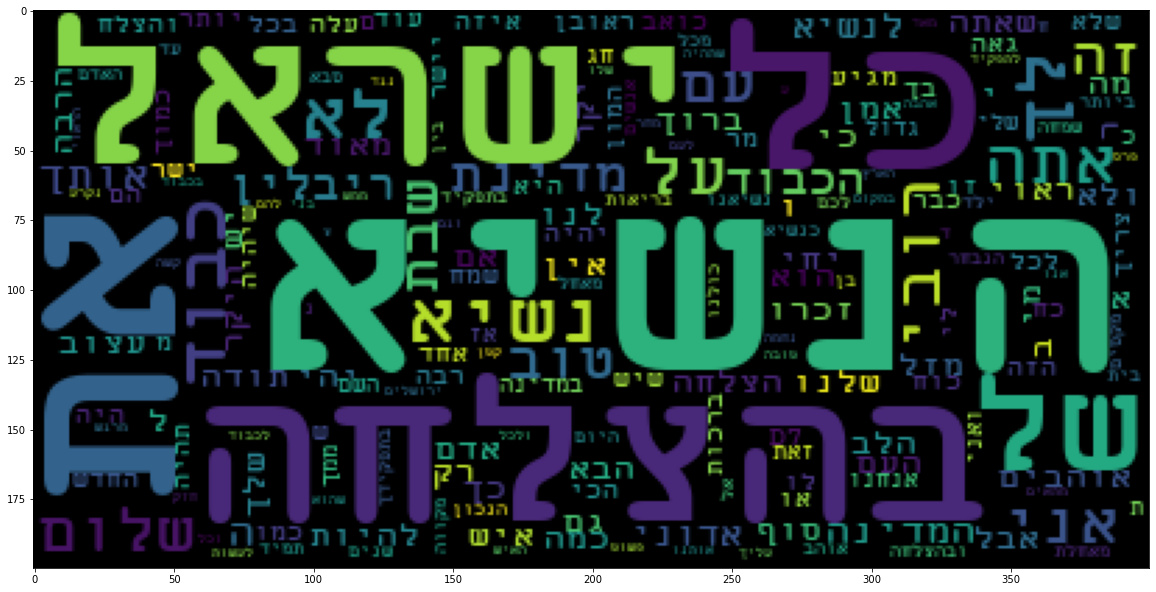

In [6]:
token_pos_freq = frequency(token_train,0)


word_list = token_train[0][token_train[1].isin([0])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - token negative
we can see here that the top words are mainly common words and conjunctions

       frequency
◊ú◊ê          2217
◊ê◊™          2170
◊©◊ú          1235
◊¢◊ú          1226
◊¢◊ù          1093
...          ...
◊ê◊§◊©◊®          65
◊ë◊¢◊ï◊ú◊ù         65
◊ë◊©◊ë◊ô◊ú         65
◊ï◊ê◊™           65
◊û◊ï◊ï◊™          65

[200 rows x 1 columns]


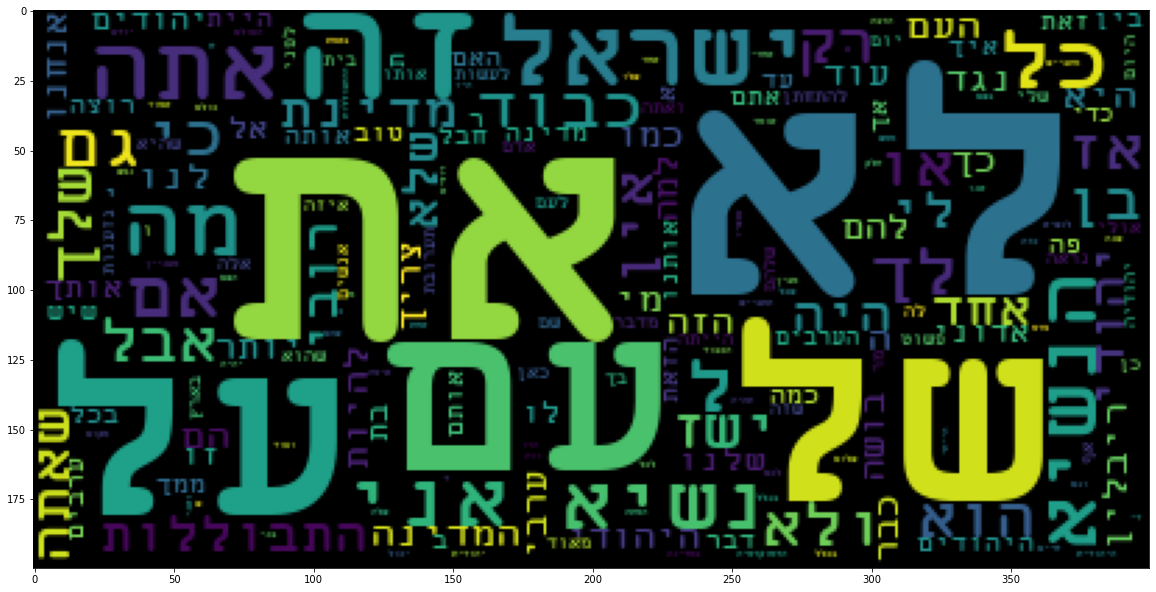

In [7]:
token_neg_freq = frequency(token_train,1)

word_list = token_train[0][token_train[1].isin([1])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - token neutral
we can see here that the top words are mainly common words and conjunctions

        frequency
◊ê◊™            189
◊©◊ú            153
◊ú◊ê            121
www            93
◊¢◊ú             91
...           ...
◊ó◊ô◊ô◊ë◊ô◊ù          7
◊ó◊ô◊ô◊ù            7
◊ô◊ê◊®◊ö            7
◊õ◊ê◊ü             7
◊õ◊ú◊ï◊ù            7

[200 rows x 1 columns]


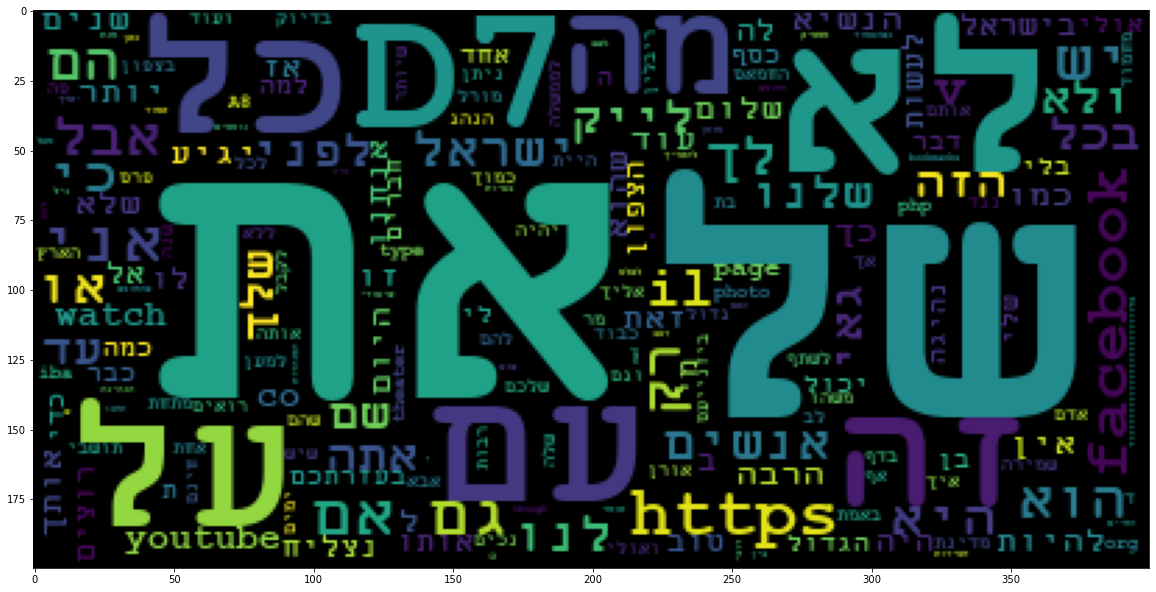

In [8]:
token_neutral_freq = frequency(token_train,2)

word_list = token_train[0][token_train[1].isin([2])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - morph positive
we can see here that we get words with positive context, but we also get common words and conjunctions

       frequency
◊†◊©◊ô◊ê        3175
◊ê◊™◊î         2927
◊ê◊™          2544
◊©◊ú          1638
◊õ◊ú          1622
...          ...
◊ê◊û◊ô◊™◊ô         58
◊ë◊®◊õ◊î          58
◊ì◊ë◊®◊ô◊ù         58
◊ô◊ú◊ì◊ô◊ù         58
◊ô◊™◊ü           58

[200 rows x 1 columns]


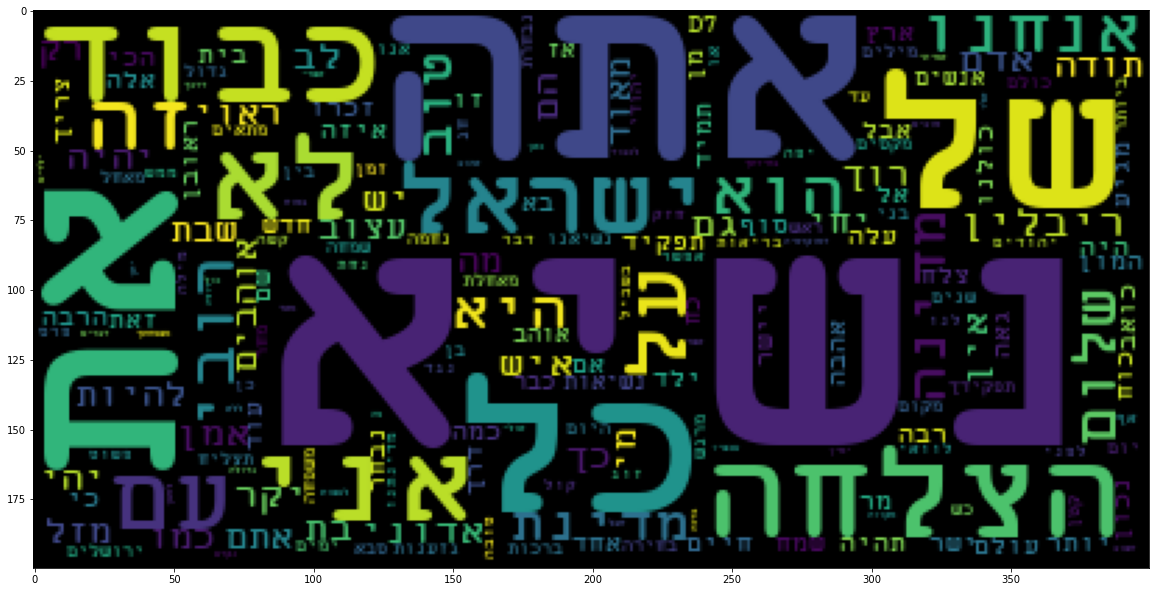

In [9]:
morph_pos_freq = frequency(morph_train, 0)

word_list = morph_train[0][morph_train[1].isin([0])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', min_word_length=2, collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - morph negative
we can see here that the top words are mainly common words and conjunctions

       frequency
◊ê◊™          3533
◊ú◊ê          2888
◊ê◊™◊î         2617
◊©◊ú          2032
◊ñ◊î          1685
...          ...
◊ó◊û◊ê◊°          63
◊õ◊ú◊ú           63
◊ú◊©◊û◊ï◊®         63
◊î◊®◊ô           62
◊¢◊ì◊ô◊£          62

[200 rows x 1 columns]


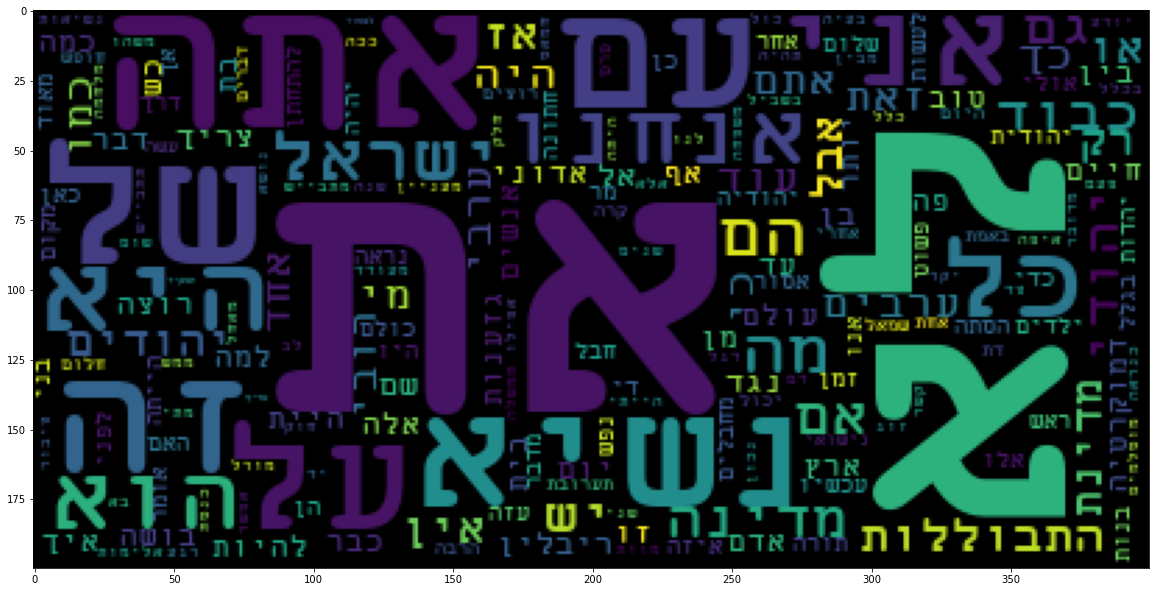

In [10]:
morph_neg_freq = frequency(morph_train, 1)

word_list = morph_train[0][morph_train[1].isin([1])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', min_word_length=2, collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

# Word frequency and WordCloud - morph neutral
we can see here that the top words are mainly common words and conjunctions

       frequency
◊ê◊™           302
◊©◊ú           216
◊ú◊ê           166
◊ê◊™◊î          145
◊õ◊ú           135
...          ...
◊ì◊ô◊ü            7
◊î◊ê◊ù            7
◊î◊í◊ì◊ï◊ú          7
◊î◊ô◊ô◊™◊î          7
◊î◊ü             7

[200 rows x 1 columns]


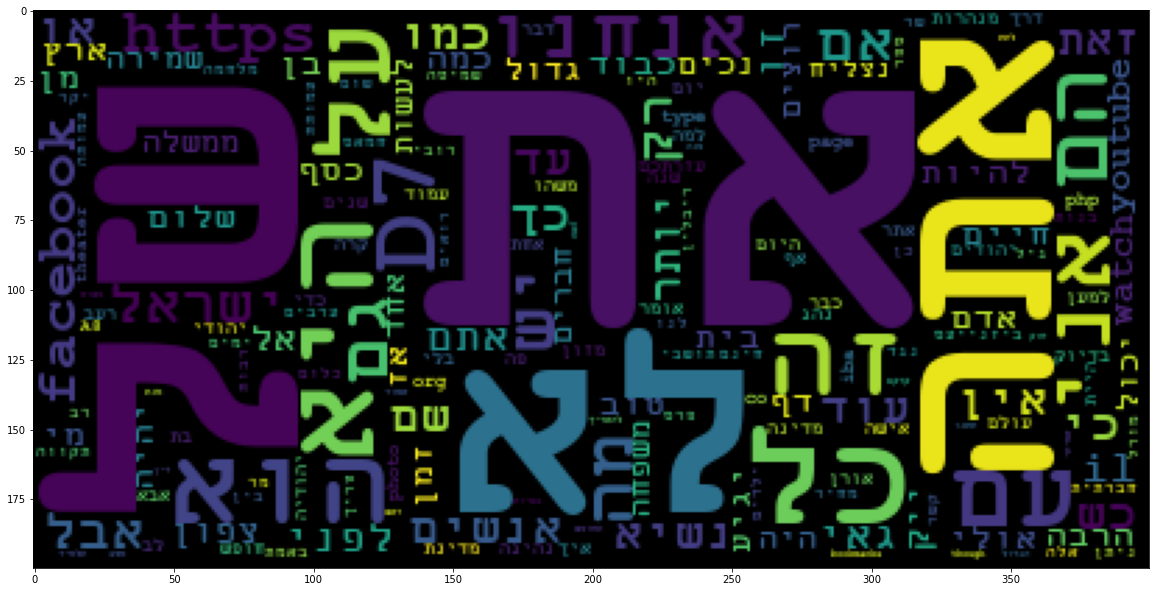

In [11]:
morph_neutral_freq = frequency(morph_train, 2)

word_list = morph_train[0][morph_train[1].isin([2])].tolist()
bow = " ".join(word_list)
bidi_text = get_display(bow)

imdb_wordcloud = WordCloud(font_path = 'C:\Windows\Fonts\courbd.ttf', min_word_length=2, collocations=False).generate(bidi_text)

plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

**Build vocabulary from words that unique for each class, words that are significant in one class but not in the other classes**

**for the basic naive classifier**

In [12]:
token_vocabulary = []
for word in token_pos_freq.index:
    if (word not in token_neg_freq.index) and (word not in token_neutral_freq.index):
        token_vocabulary.append(word)
for word in token_neg_freq.index:
    if (word not in token_pos_freq.index) and (word not in token_neutral_freq.index):
        token_vocabulary.append(word)
for word in token_neutral_freq.index:
    if (word not in token_pos_freq.index) and (word not in token_neg_freq.index):
        token_vocabulary.append(word)

In [13]:
morph_vocabulary = []
for word in morph_pos_freq.index:
    if (word not in morph_neg_freq.index) and (word not in morph_neutral_freq.index):
        morph_vocabulary.append(word)
for word in token_neg_freq.index:
    if (word not in morph_pos_freq.index) and (word not in morph_neutral_freq.index):
        morph_vocabulary.append(word)
for word in token_neutral_freq.index:
    if (word not in morph_pos_freq.index) and (word not in morph_neg_freq.index):
        morph_vocabulary.append(word)
morph_vocabulary = list(dict.fromkeys(morph_vocabulary))

## Plot train data sentiments distribution
We can see that most of the comments are possitive

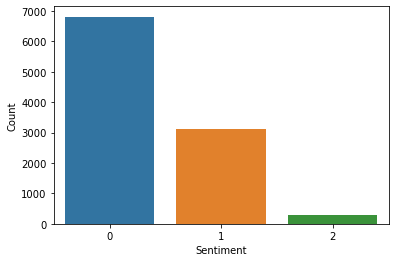

In [14]:
ax = sns.countplot(x=1, data=token_train);
ax.set(xlabel='Sentiment', ylabel='Count')
plt.show()

## FIRST MODEL
Using Random Forest classifier based on TD-IDF

## Prepare the data for models

In [15]:
#token_train_eng = token_train_eng[token_train_eng[1] < 2]
#token_test_eng = token_test_eng[token_test_eng[1] < 2]

In [16]:
#Split all data sets to the comments(X) and the sentimnet(y) 

'''
X_token_train = token_train.iloc[:, 0].values
y_token_train = token_train.iloc[:, 1].values
X_token_test = token_test.iloc[:, 0].values
y_token_test = token_test.iloc[:, 1].values

X_morph_train = morph_train.iloc[:, 0].values
y_morph_train = morph_train.iloc[:, 1].values
X_morph_test = morph_test.iloc[:, 0].values
y_morph_test = morph_test.iloc[:, 1].values


X_token_train_eng = token_train_eng.iloc[:, 0].values
y_token_train_eng = token_train_eng.iloc[:, 1].values
X_token_test_eng = token_test_eng.iloc[:, 0].values
y_token_test_eng = token_test_eng.iloc[:, 1].values'''

'\nX_token_train = token_train.iloc[:, 0].values\ny_token_train = token_train.iloc[:, 1].values\nX_token_test = token_test.iloc[:, 0].values\ny_token_test = token_test.iloc[:, 1].values\n\nX_morph_train = morph_train.iloc[:, 0].values\ny_morph_train = morph_train.iloc[:, 1].values\nX_morph_test = morph_test.iloc[:, 0].values\ny_morph_test = morph_test.iloc[:, 1].values\n\n\nX_token_train_eng = token_train_eng.iloc[:, 0].values\ny_token_train_eng = token_train_eng.iloc[:, 1].values\nX_token_test_eng = token_test_eng.iloc[:, 0].values\ny_token_test_eng = token_test_eng.iloc[:, 1].values'

In [17]:
#proccess_text function will get text array and clean it with regex expressions
def process_text(arr, lang):
    processed_arr = []
    
    if lang=="he":
        for text in range(0, len(arr)):  
            processed_text = re.sub(r'[\a-z]+', ' ', str(arr[text]))
            processed_arr.append(processed_text)
            
    elif lang=="eng":
        for text in range(0, len(arr)):  
            # Remove all the special characters
            processed_text = re.sub(r'\W', ' ', str(arr[text]))

            # Remove all digits
            #processed_text = re.sub(r'\d+', ' ', processed_text)

            # remove all single characters
            processed_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)

            # Remove single characters from the start
            processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text) 

            # Substituting multiple spaces with single space
            processed_text= re.sub(r'\s+', ' ', processed_text, flags=re.I)

            # Removing prefixed 'b'
            processed_text = re.sub(r'^b\s+', '', processed_text)

            # Converting to Lowercase
            processed_text = processed_text.lower()
            processed_arr.append(processed_text)
    
    return processed_arr

In [18]:
#Clean Datasets

'''X_token_train_processed = process_text(X_token_train,"he")
X_token_test_processed = process_text(X_token_test,"he")

X_morph_train_processed = process_text(X_morph_train,"he")
X_morph_test_processed = process_text(X_morph_test,"he")

X_token_train_eng_processed = token_train_eng(X_token_train_eng,"eng")
X_token_test_eng_processed = process_text(X_token_test_eng,"eng")'''

'X_token_train_processed = process_text(X_token_train,"he")\nX_token_test_processed = process_text(X_token_test,"he")\n\nX_morph_train_processed = process_text(X_morph_train,"he")\nX_morph_test_processed = process_text(X_morph_test,"he")\n\nX_token_train_eng_processed = token_train_eng(X_token_train_eng,"eng")\nX_token_test_eng_processed = process_text(X_token_test_eng,"eng")'

In [19]:
#token_train_eng[0] = process_text(token_train_eng[0],"eng")

In [20]:
#token_train_eng[:5]

In [21]:
token_train[0] = process_text(token_train[0],"he")
token_test[0] = process_text(token_test[0],"he")

morph_train[0] = process_text(morph_train[0],"he")
morph_test[0] = process_text(morph_test[0],"he")

token_train_eng[0] = process_text(token_train_eng[0],"eng")
token_test_eng[0] = process_text(token_test_eng[0],"eng")

In [22]:
#Split all data sets to the comments(X) and the sentimnet(y) 


X_token_train = token_train.iloc[:, 0].values
y_token_train = token_train.iloc[:, 1].values
X_token_test = token_test.iloc[:, 0].values
y_token_test = token_test.iloc[:, 1].values

X_morph_train = morph_train.iloc[:, 0].values
y_morph_train = morph_train.iloc[:, 1].values
X_morph_test = morph_test.iloc[:, 0].values
y_morph_test = morph_test.iloc[:, 1].values


X_token_train_eng = token_train_eng.iloc[:, 0].values
y_token_train_eng = token_train_eng.iloc[:, 1].values
X_token_test_eng = token_test_eng.iloc[:, 0].values
y_token_test_eng = token_test_eng.iloc[:, 1].values

# New Model - Naive classifier 
**based on the vocabularies that i build with the unique words for each class**

In [23]:
#token based

In [24]:
#vectorize by the vocabulary
count_vect_token = CountVectorizer(vocabulary=token_vocabulary)
count_vect_token.fit(X_token_train)

CountVectorizer(vocabulary=['◊ë◊î◊¶◊ú◊ó◊î', '◊©◊ë◊™', '◊ê◊ô◊©', '◊ê◊û◊ü', '◊î◊ú◊ë', '◊ô◊ó◊ô', '◊ë◊®◊ï◊ö',
                            '◊û◊ñ◊ú', '◊ô◊ß◊®', '◊ô◊î◊ô', '◊î◊¶◊ú◊ó◊î', '◊™◊ï◊ì◊î', '◊ê◊ï◊î◊ë◊ô◊ù',
                            '◊ñ◊õ◊®◊ï', '◊®◊ê◊ï◊ô', '◊¢◊¶◊ï◊ë', '◊°◊ï◊£', '◊î◊ô◊ß◊®', '◊î◊ë◊ê',
                            '◊®◊ê◊ï◊ë◊ü', '◊®◊ë◊î', '◊ô◊©◊®', '◊¢◊ú◊î', '◊î◊õ◊ô', '◊©◊û◊ó', '◊î◊û◊ï◊ü',
                            '◊õ◊ï◊ê◊ë', '◊î◊ó◊ì◊©', '◊ï◊î◊¶◊ú◊ó', '◊õ◊ï◊ó', ...])

In [25]:
X_token_train_counts = count_vect_token.transform(X_token_train)
X_token_test_counts = count_vect_token.transform(X_token_test)

In [26]:
token_my_voc_train = pd.DataFrame.sparse.from_spmatrix(X_token_train_counts)
token_my_voc_test = pd.DataFrame.sparse.from_spmatrix(X_token_test_counts)

In [27]:
token_my_voc_train_arr = token_my_voc_train.to_numpy()
token_my_voc_test_arr = token_my_voc_test.to_numpy()

In [28]:
#use MultinomialNB for the classification
MNB = MultinomialNB()
MNB.fit(token_my_voc_train_arr, y_token_train)
y_pred = MNB.predict(token_my_voc_test_arr)
print("Accuracy:",metrics.accuracy_score(y_token_test, y_pred))

Accuracy: 0.808984375


# False Positives, True Positives - Explantion

In [29]:
# print poisitive rows that classified wrong
pos_org = np.where(y_token_test == 0)
count = 0
for i in pos_org[0]:
    pos_pred = np.where(y_pred == 0)
    if i not in pos_pred[0]:
        print(i)
        print(X_token_test[i])
        rec_words = np.where(token_my_voc_test_arr[i] != 0)
        print("classified words:")
        for word in rec_words[0]:
            print(count_vect_token.get_feature_names()[word])
        count += 1
        print("\n")
print(count)

25
◊ê◊ì◊ï◊†◊ô ◊î◊†◊©◊ô◊ê ◊õ◊ú ◊ë◊†◊ê◊ì◊ù ◊¶◊®◊ô◊ö ◊ú◊ó◊™◊ï◊ù ◊¢◊ú ◊ñ◊î ◊¶◊®◊ô◊ö ◊ú◊î◊ï◊¶◊ô◊ê ◊ó◊ï◊ß ◊ë◊õ◊ú◊ú ◊©◊õ◊ï◊ú ◊ë◊†◊ì◊ù ◊©◊†◊û◊û◊™◊ï ◊¢◊ú◊™◊î ◊ú◊û◊¢◊ú◊î ◊¶◊®◊ô◊ö ◊ú◊ô◊™◊®◊ï◊ù ◊ê◊™ ◊í◊ï◊§◊ï ◊ú◊ê◊†◊©◊ô◊ù ◊ê◊ó◊®◊ô◊ù ◊ú◊ê ◊¶◊®◊ô◊ö ◊ê◊™ ◊ñ◊î ◊ú◊û◊™◊î ◊ú◊ê◊ï◊¶◊ô◊ê ◊ó◊ï◊ß ◊ï◊ñ◊î ◊ë◊°◊ì◊® ◊ú◊ô ◊ô◊© ◊ê◊™ ◊ñ◊î ◊ú◊§◊†◊î ◊©◊†◊î ◊ê◊†◊ô ◊ó◊™◊û◊™◊ô ◊ï◊ê◊†◊ô ◊û◊¶◊ô◊¢ ◊ú◊õ◊ï◊ú◊ù ◊ë◊ë◊ß◊©◊î ◊™◊ó◊™◊û◊ï ◊õ◊û◊ï ◊©◊ê◊™◊ù ◊¢◊ï◊ñ◊®◊ô◊ù ◊ú◊ê◊†◊©◊ô◊ù ◊©◊ê◊ù ◊ë◊ó◊ô◊ô◊ù ◊™◊¢◊ñ◊®◊ï ◊ú◊ê◊†◊©◊ô◊ù ◊í◊ù ◊©◊ê◊™◊ù ◊û◊™◊ô◊ù ◊ó◊©◊ï◊ë
classified words:
◊ë◊õ◊ú◊ú
◊ï◊ñ◊î


33
◊ì◊ô◊ô ◊ú◊ì◊™◊ô◊ï◊™ ◊î◊§◊†◊ê◊ò◊ô◊™ ◊î◊ñ◊ê◊™ ◊©◊û◊§◊ú◊í◊™ ◊ë◊†◊ô ◊ê◊ì◊ù ◊ë◊ú◊ô ◊©◊ï◊ù ◊°◊ô◊ë◊î ◊î◊í◊ô◊ï◊†◊ô◊™ ◊ô◊© ◊§◊î ◊û◊ê◊ë◊ß ◊ë◊ô◊ü ◊û◊ó◊†◊î ◊©◊®◊ï◊¶◊î ◊ê◊ó◊ï◊ï◊î ◊ê◊†◊ï◊©◊ô◊™ ◊ú◊û◊ó◊†◊î ◊©◊®◊ï◊¶◊î ◊§◊ô◊ú◊ï◊í ◊ê◊†◊ï◊©◊ô ◊ú◊ê ◊ß◊©◊î ◊ú◊®◊ê◊ï◊™ ◊ê◊ô◊ñ◊î ◊¶◊ì ◊ô◊™◊ê◊ô◊ù ◊ô◊ï◊™◊® ◊ú◊¢◊ï◊ú◊ù ◊©◊û◊ó 
classified words:
◊©◊û◊ó
◊ß◊©◊î
◊î◊ñ◊ê◊™
◊©◊ï◊ù
◊ë◊ú◊ô


35
 ◊û◊¶◊ï◊ô◊ô◊ü ◊ê◊™◊î ◊ë◊¢◊û◊ì◊î ◊ô◊ï◊¶◊ê◊™ ◊ì◊ï◊§◊ü ◊ú◊™◊™ ◊™◊ß◊ï◊ï◊î ◊ú◊õ◊ú ◊ê◊ú◊î ◊û◊ê◊ô◊™

**We can see that in some rows that classified wrong we can find words that can interpreted as negative for example:**
- row 33 - ◊ß◊©◊î
- row 57 - ◊¢◊®◊ë◊ô
- row 73 - ◊™◊™◊ë◊ô◊ô◊©
- row 203 - ◊™◊¢◊®◊ï◊ë◊™

**but in this model we have a lot of rows that we don't recognize enough words or that we recognized word as negative but they aren't negative necessity**

In [30]:
# print negative rows that classified wrong
neg_org = np.where(y_token_test == 1)
count = 0
for i in neg_org[0]:
    neg_pred = np.where(y_pred == 1)
    if i not in neg_pred[0]:
        print(i)
        print(X_token_test[i])
        rec_words = np.where(token_my_voc_test_arr[i] != 0)
        print("classified words:")
        for word in rec_words[0]:
            print(count_vect_token.get_feature_names()[word])
        count += 1
        print("\n")
print(count)

27
 ◊ñ◊î ◊ú◊ê ◊ß◊©◊ï◊® ◊ú◊í◊ñ◊¢◊†◊ï◊™ ◊ñ◊î ◊ß◊©◊ï◊® ◊ú◊î◊™◊ë◊ï◊ú◊ú◊ï◊™ ◊©◊ë◊í◊ú◊ú◊î ◊ß◊ô◊ë◊ú◊†◊ï ◊¢◊ï◊†◊© ◊ê◊™ ◊î◊©◊ï◊ê◊î ◊ê◊ù ◊ë◊ó◊ï◊ß◊ï◊™◊ô ◊™◊ú◊õ◊ï ◊ï◊ê◊ù ◊ú◊ê ◊ê◊ñ 
classified words:


72
◊ñ◊ï◊î◊®◊î ◊õ◊ï◊ú◊†◊ï ◊õ◊î◊†◊ê 
classified words:
◊õ◊ï◊ú◊†◊ï


75
 ◊¢◊õ◊©◊ô◊ï ◊†◊î◊ô◊ô◊™ ◊†◊©◊ô◊ê ◊õ◊ì◊ô ◊©◊†◊©◊û◊¢ ◊ê◊™ ◊î◊©◊ò◊ï◊ô◊ï◊™ ◊©◊ê◊™◊î ◊õ◊ï◊™◊ë ◊¢◊ñ◊ï◊ë ◊™◊î◊†◊î ◊û◊î◊û◊©◊õ◊ï◊®◊™ ◊ï◊™◊©◊ê◊ô◊® ◊ê◊ï◊™◊†◊ï ◊¢◊ù ◊î◊¶◊®◊ï◊™ ◊©◊î◊û◊û◊©◊ú◊î ◊¢◊ï◊©◊î ◊ú◊†◊ï ◊™◊ï◊ì◊î 
classified words:
◊™◊ï◊ì◊î
◊¢◊õ◊©◊ô◊ï


96
◊°◊¢ ◊°◊¢ ◊ú◊ú◊§◊ú◊†◊ì ◊¢◊©◊ô◊™ ◊™◊§◊ì◊ô◊ó◊î ◊©◊ú◊ö
classified words:


98
 ◊ú◊õ◊ú ◊û◊ô ◊©◊ß◊ï◊®◊ê ◊ê◊™ ◊î◊™◊í◊ï◊ë◊ï◊™ ◊î◊©◊§◊ï◊ô◊ï◊™ ◊ï◊ú◊ê ◊û◊°◊õ◊ô◊ù ◊ê◊ô◊™◊ù ◊©◊ô◊ì◊¢ ◊©◊î◊†◊©◊ô◊ê ◊©◊ú ◊î◊û◊ì◊ô◊†◊î ◊©◊ú◊ï ◊°◊ï◊ë◊® ◊õ◊û◊ï◊î◊ï ◊ú◊û◊®◊ë◊î ◊î◊¶◊¢◊® 
classified words:


107
 ◊ñ◊î ◊õ◊û◊ï◊ë◊ü ◊ú◊ê ◊ò◊®◊ï◊® ◊ï◊í◊ù ◊ú◊ê ◊û◊°◊õ◊ü ◊ê◊™ ◊ß◊ô◊ï◊û◊†◊ï ◊ê◊ñ ◊ú◊ê ◊¶◊®◊ô◊ö ◊ú◊í◊†◊ï◊™ 
classified words:


109
◊®◊ï◊ë◊ô ◊®◊ô◊ë◊ú◊ô◊ü ◊ê◊†◊ô ◊ë◊ñ ◊ú◊ö 
classified words:


121
 ◊ú◊™◊©◊ï◊û◊™ ◊ú◊ô◊ë◊õ◊ù ◊ú◊û◊ò◊î

1905
◊î◊†◊î ◊ú◊û◊©◊ú ◊ë◊û◊ó◊ô◊ú◊î ◊û◊õ◊ë◊ï◊ì◊ö ◊ê◊ó◊ì ◊°◊®◊ê◊ë◊ß ◊¢◊®◊° ◊ó◊§◊®◊™◊ù ◊¢◊ú ◊ñ◊î ◊ô◊ë◊†◊ô ◊ñ◊ï◊†◊ï◊™ ◊ï◊®◊ê◊ì◊ô ◊¢◊ï◊ì ◊ô◊ï◊™◊® ◊ë◊ü ◊ñ◊ï◊†◊î ◊§◊ï◊ú◊ô◊ò◊ô◊ß◊ê◊ô◊ù ◊û◊°◊®◊ô◊ó◊ô◊ù ◊©◊û◊ó◊§◊©◊ô◊ù ◊ë◊û◊î ◊î◊©◊ù ◊ë◊û◊í◊ô◊ë◊ô◊ù 
classified words:


1906
◊ê◊ú ◊™◊ú◊û◊ì ◊ê◊ï◊™◊†◊ï ◊™◊ï◊®◊î ◊ó◊¶◊ï◊£ 
classified words:


1916
 ◊ê◊ì◊ï◊†◊ô ◊î◊†◊©◊ô◊ê ◊î◊ë◊ê ◊ë◊ô◊®◊ï◊©◊ú◊ô◊ù ◊ô◊ï◊©◊ë◊ô◊ù ◊©◊ï◊§◊ò◊ô◊ù ◊©◊î◊ù ◊í◊ô◊° ◊ó◊û◊ô◊©◊ô ◊ë◊õ◊†◊°◊™ ◊ô◊© ◊û◊û◊©◊ú◊î ◊©◊ú ◊ê◊§◊°◊ô◊ù ◊°◊û◊®◊ò◊ï◊ò◊ô◊ù ◊§◊ó◊ì◊†◊ô◊ù ◊ï◊ë◊õ◊†◊°◊™ ◊ô◊ï◊©◊ë◊ô◊ù ◊ô◊î◊ï◊ì◊ï◊†◊ô◊ù ◊ß◊ò◊†◊ô◊ù ◊§◊ó◊ì◊†◊ô◊ù ◊ï◊õ◊†◊ï◊¢◊ô◊ù 
classified words:
◊î◊ë◊ê


1919
◊†◊ë◊ó◊®◊™ ◊ï◊†◊î◊ô◊ô◊™ ◊©◊û◊ê◊ú◊ü ◊ë◊ô◊ë◊ô ◊¶◊ì◊ß
classified words:


1930
◊û◊ô ◊û◊î◊í◊ï◊ô◊ô◊ù ◊î◊™◊§◊ú◊ú ◊¢◊ú ◊î◊ë◊†◊ô◊ù ◊®◊ß ◊ê◊†◊ó◊†◊ï ◊ú◊ë◊ô◊ü ◊¢◊¶◊û◊ô◊†◊ï ◊ë◊ï◊õ◊ô◊ù ◊¢◊ú ◊ê◊ó◊ô◊†◊ï ◊©◊ô◊ó◊ñ◊®◊ï ◊û◊û◊© ◊ú◊ê ◊î◊í◊ï◊ô◊ô◊ù ◊ê◊¶◊ú◊î◊ù ◊ê◊ï◊ú◊ô ◊ñ◊ê◊™ ◊¶◊ë◊ô◊¢◊ï◊™ 
classified words:


1935
 ◊û◊® ◊†◊™◊†◊ô◊î◊ï ◊ê◊™ ◊û◊©◊î ◊ô◊¢◊ú◊ï◊ü ◊û◊ó◊® ◊ë◊©◊¢◊î ◊ë◊ë◊ï◊ß◊® ◊î◊û◊ó◊ë◊ú◊ô◊ù ◊ô◊§◊™◊ó◊

**We can see that in some rows that classified wrong we can find words that can interpreted as positive for example:**
- row 121 - ◊ò◊ï◊ë◊î, ◊ó◊ë◊®◊ô◊ù
- row 129 - ◊ú◊ô◊ô◊ß
- row 138 - ◊ô◊ß◊®
- row 203 - ◊™◊¢◊®◊ï◊ë◊™

**We can see also that we have a lot of rows that we didn't recognize any word - probably because the vocabulary isn't contain enough words**

In [31]:
#morph based

In [32]:
count_vect_morph = CountVectorizer(vocabulary=morph_vocabulary)
count_vect_morph.fit(X_morph_train)

CountVectorizer(vocabulary=['◊î◊¶◊ú◊ó◊î', '◊ê◊ô◊©', '◊ê◊û◊ü', '◊®◊ê◊ï◊ô', '◊ô◊ó◊ô', '◊û◊ñ◊ú', '◊®◊ï◊ö',
                            '◊ô◊î◊ô', '◊™◊ï◊ì◊î', '◊©◊ë◊™', '◊ê◊ï◊î◊ë◊ô◊ù', '◊¢◊¶◊ï◊ë', '◊™◊§◊ß◊ô◊ì',
                            '◊°◊ï◊£', '◊ñ◊õ◊®◊ï', '◊ô◊©◊®', '◊®◊ê◊ï◊ë◊ü', '◊®◊ë◊î', '◊î◊û◊ï◊ü', '◊î◊õ◊ô',
                            '◊¢◊ú◊î', '◊©◊û◊ó', '◊ó◊ì◊©', '◊õ◊ï◊ê◊ë', '◊†◊ë◊ó◊®', '◊¶◊ú◊ó', '◊ô◊ú◊ì',
                            '◊û◊í◊ô◊¢', '◊ô◊ô◊©◊®', '◊õ◊ï◊ó', ...])

In [33]:
X_morph_train_counts = count_vect_morph.transform(X_morph_train)
X_morph_test_counts = count_vect_morph.transform(X_morph_test)

In [34]:
morph_my_voc_train = pd.DataFrame.sparse.from_spmatrix(X_morph_train_counts)
morph_my_voc_test = pd.DataFrame.sparse.from_spmatrix(X_morph_test_counts)

In [35]:
morph_my_voc_train_arr = morph_my_voc_train.to_numpy()
morph_my_voc_test_arr = morph_my_voc_test.to_numpy()

In [36]:
MNB = MultinomialNB()
MNB.fit(morph_my_voc_train_arr, y_morph_train)
y_pred = MNB.predict(morph_my_voc_test_arr)
print("Accuracy:",metrics.accuracy_score(y_token_test, y_pred))

Accuracy: 0.7859375


**We see that also with naive classifier that based on unique words of each class we get 80%~ accuracy**

## FIRST MODEL
Using Random Forest classifier based on TD-IDF

Create feature vectors containing TF-IDF values
- max_features - The number of words that we will create feature for.
- min_df - Specify that a word should be occur at least 5 times to treat as feature
- max_df = Specify that a word will not occur in more of 70% of the data

In [37]:
tfidf_token_converter = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.7)  

tfidf_morph_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

tfidf_token_eng_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

In [38]:
#We will use only the train data to fit (create the features) and than we will transform both train and dataset.

tfidf_token_converter.fit(X_token_train)
X_token_train = tfidf_token_converter.transform(X_token_train).toarray()
X_token_test = tfidf_token_converter.transform(X_token_test).toarray()

tfidf_morph_converter.fit(X_morph_train)
X_morph_train = tfidf_morph_converter.transform(X_morph_train).toarray()
X_morph_test = tfidf_morph_converter.transform(X_morph_test).toarray()

tfidf_token_eng_converter.fit(X_token_train_eng)
X_token_train_eng = tfidf_token_eng_converter.transform(X_token_train_eng).toarray()
X_token_test_eng = tfidf_token_eng_converter.transform(X_token_test_eng).toarray()

In [39]:
#get top weighting feature (the more rare words get more weight in tdidf) and words with the lowest weight (more common words)
def get_edge_words(converter, amount):
    indices = np.argsort(converter.idf_)[::-1]
    features = converter.get_feature_names()
    top_features = [features[i] for i in indices[:amount]]
    low_features = [features[i] for i in indices[(len(features)-amount):]]
    print("Top weight words:")
    print(top_features)
    print("\nLow weight words:")
    print(low_features)

In [40]:
get_edge_words(tfidf_token_converter, 20)

Top weight words:
['◊ë◊¶◊§◊ï◊ü', '◊ó◊ï', '◊í◊®◊ô◊ù', '◊ï◊ê◊ï◊î◊ì', '◊†◊õ◊ô◊ù', '◊ô◊†◊ï', '◊û◊ô◊ì◊ù', '◊ô◊ö', '◊ë◊ô◊ñ◊†◊ô◊ô◊¢◊°', '◊ñ◊®', '◊ï◊ú◊™◊™', '◊û◊©◊ï◊™◊§◊ô◊ù', '◊í◊ô◊ú◊ï◊ô◊ô', '◊û◊î◊¶◊ô◊ë◊ï◊®', '◊ë◊ú◊î', '◊î◊û◊°◊®', '◊ô◊ß◊ë◊ú◊ï', '◊ï◊ê◊ó◊®', '◊î◊û◊†◊î◊®◊ï◊™', '◊¢◊†◊ô◊ô◊ù']

Low weight words:
['◊í◊ù', '◊û◊ì◊ô◊†◊™', '◊®◊ô◊ë◊ú◊ô◊ü', '◊û◊î', '◊®◊ï◊ë◊ô', '◊ë◊î◊¶◊ú◊ó◊î', '◊ê◊†◊ô', '◊ú◊ö', '◊ñ◊î', '◊¢◊ù', '◊õ◊ë◊ï◊ì', '◊ê◊™◊î', '◊ô◊©◊®◊ê◊ú', '◊¢◊ú', '◊†◊©◊ô◊ê', '◊õ◊ú', '◊©◊ú', '◊ú◊ê', '◊ê◊™', '◊î◊†◊©◊ô◊ê']


In [41]:
get_edge_words(tfidf_morph_converter, 20)

Top weight words:
['◊ô◊ö', '◊ë◊ú◊î', '◊î◊ï◊®◊ê◊î', '◊¢◊û◊ï◊™◊î', '◊™◊ï', '◊¢◊ñ◊®◊™◊õ◊ù', '◊û◊©◊ê', '◊¢◊û◊ú◊ß', '◊¢◊°◊ß◊ô◊ù', '◊ê◊ô◊û◊ê', '◊™◊ó◊ë◊ï◊®◊î', '◊ë◊†◊ö', '◊ú◊ë◊ß◊®', '◊†◊î◊®◊í◊ï', '◊®◊¢◊ë', '◊ô◊î◊ï◊î', '◊û◊©◊õ◊ï◊®◊ï◊™', '◊ô◊î', '◊ê◊ï◊ò◊ï◊ë◊ï◊°', '◊©◊ô◊ì◊ï◊®']

Low weight words:
['◊ô◊©', '◊û◊ì◊ô◊†◊î', '◊û◊î', '◊®◊ï◊ë◊ô', '◊î◊ô◊ê', '◊î◊ï◊ê', '◊ê◊†◊ó◊†◊ï', '◊î◊¶◊ú◊ó◊î', '◊ô◊©◊®◊ê◊ú', '◊¢◊ú', '◊ñ◊î', '◊ê◊†◊ô', '◊õ◊ë◊ï◊ì', '◊¢◊ù', '◊õ◊ú', '◊ú◊ê', '◊©◊ú', '◊ê◊™◊î', '◊ê◊™', '◊†◊©◊ô◊ê']


In [42]:
get_edge_words(tfidf_token_eng_converter, 20)

Top weight words:
['zvi', 'test', 'hunger', 'hungry', '9e', 'iba', 'thee', 'avraham', 'remained', 'salvation', 'driver', 'flock', 'unclean', 'strengthens', 'a0', 'liberate', 'threat', 'anthem', 'judges', 'sanctification']

Low weight words:
['who', 'have', 'with', 'israel', 'your', 'be', 'it', 'for', 'are', 'will', 'that', 'not', 'is', 'in', 'president', 'to', 'you', 'of', 'and', 'the']


## Build Classifier
I will use random forest to classify the data

In [43]:
token_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
token_classifier.fit(X_token_train, y_token_train)

morph_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
morph_classifier.fit(X_morph_train, y_morph_train)

token_eng_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
token_eng_classifier.fit(X_token_train_eng, y_token_train_eng)

RandomForestClassifier(random_state=0)

## Predict

In [44]:
token_predictions = token_classifier.predict(X_token_test)
morph_predictions = morph_classifier.predict(X_morph_test)
token_eng_predictions = token_eng_classifier.predict(X_token_test_eng)

We can see that we get similiar results in all datasets ~92% accuracy.

In [45]:
print("token model")
print(confusion_matrix(y_token_test, token_predictions))  
print(classification_report(y_token_test, token_predictions))  
print(accuracy_score(y_token_test, token_predictions))

print("\nmorph model")
print(confusion_matrix(y_morph_test, morph_predictions))  
print(classification_report(y_morph_test, morph_predictions))  
print(accuracy_score(y_morph_test, morph_predictions))

print("token_eng model")
print(confusion_matrix(y_token_test_eng, token_eng_predictions))  
print(classification_report(y_token_test_eng, token_eng_predictions))  
print(accuracy_score(y_token_test_eng, token_eng_predictions))

token model
[[1622   74    2]
 [  91  698    1]
 [  20   15   37]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1698
           1       0.89      0.88      0.89       790
           2       0.93      0.51      0.66        72

    accuracy                           0.92      2560
   macro avg       0.92      0.78      0.83      2560
weighted avg       0.92      0.92      0.92      2560

0.920703125

morph model
[[1634   61    3]
 [ 100  690    0]
 [  17   18   37]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1698
           1       0.90      0.87      0.89       790
           2       0.93      0.51      0.66        72

    accuracy                           0.92      2560
   macro avg       0.92      0.78      0.83      2560
weighted avg       0.92      0.92      0.92      2560

0.922265625
token_eng model
[[1643   48    7]
 [ 102  684    4]
 [  16   15   41]]
        

We can see the diffrences between the features of the datasets

# print feature importance graph of the random forest model

In [62]:
def print_feature_importances(df, classifier, converter):

    # Preparing variables
    importances = classifier.feature_importances_
    feature_names = converter.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

Feature ranking:
feature 1577 : ◊ú◊ê (0.035327)
feature 1986 : ◊û◊î (0.019590)
feature 1208 : ◊ñ◊î (0.016594)
feature 197 : ◊ê◊™ (0.015729)
feature 250 : ◊ë◊î◊¶◊ú◊ó◊î (0.015220)
feature 982 : ◊î◊™◊ë◊ï◊ú◊ú◊ï◊™ (0.014118)
feature 2429 : ◊¢◊ù (0.012721)
feature 2415 : ◊¢◊ú (0.010512)
feature 265 : ◊ë◊ï◊©◊î (0.010308)
feature 858 : ◊î◊†◊©◊ô◊ê (0.009269)
feature 141 : ◊ê◊ù (0.008136)
feature 2456 : ◊¢◊®◊ë◊ô (0.007780)
feature 198 : ◊ê◊™◊î (0.007528)
feature 1378 : ◊ô◊î◊ï◊ì◊ô (0.007200)
feature 1784 : ◊ú◊û◊î (0.007169)
feature 2774 : ◊©◊ú (0.007035)
feature 59 : ◊ê◊ñ (0.006805)
feature 2989 : ◊™◊™◊ë◊ô◊ô◊© (0.006690)
feature 747 : ◊î◊ô◊î◊ï◊ì◊ô (0.006499)
feature 2394 : ◊¢◊ï◊ì (0.006316)


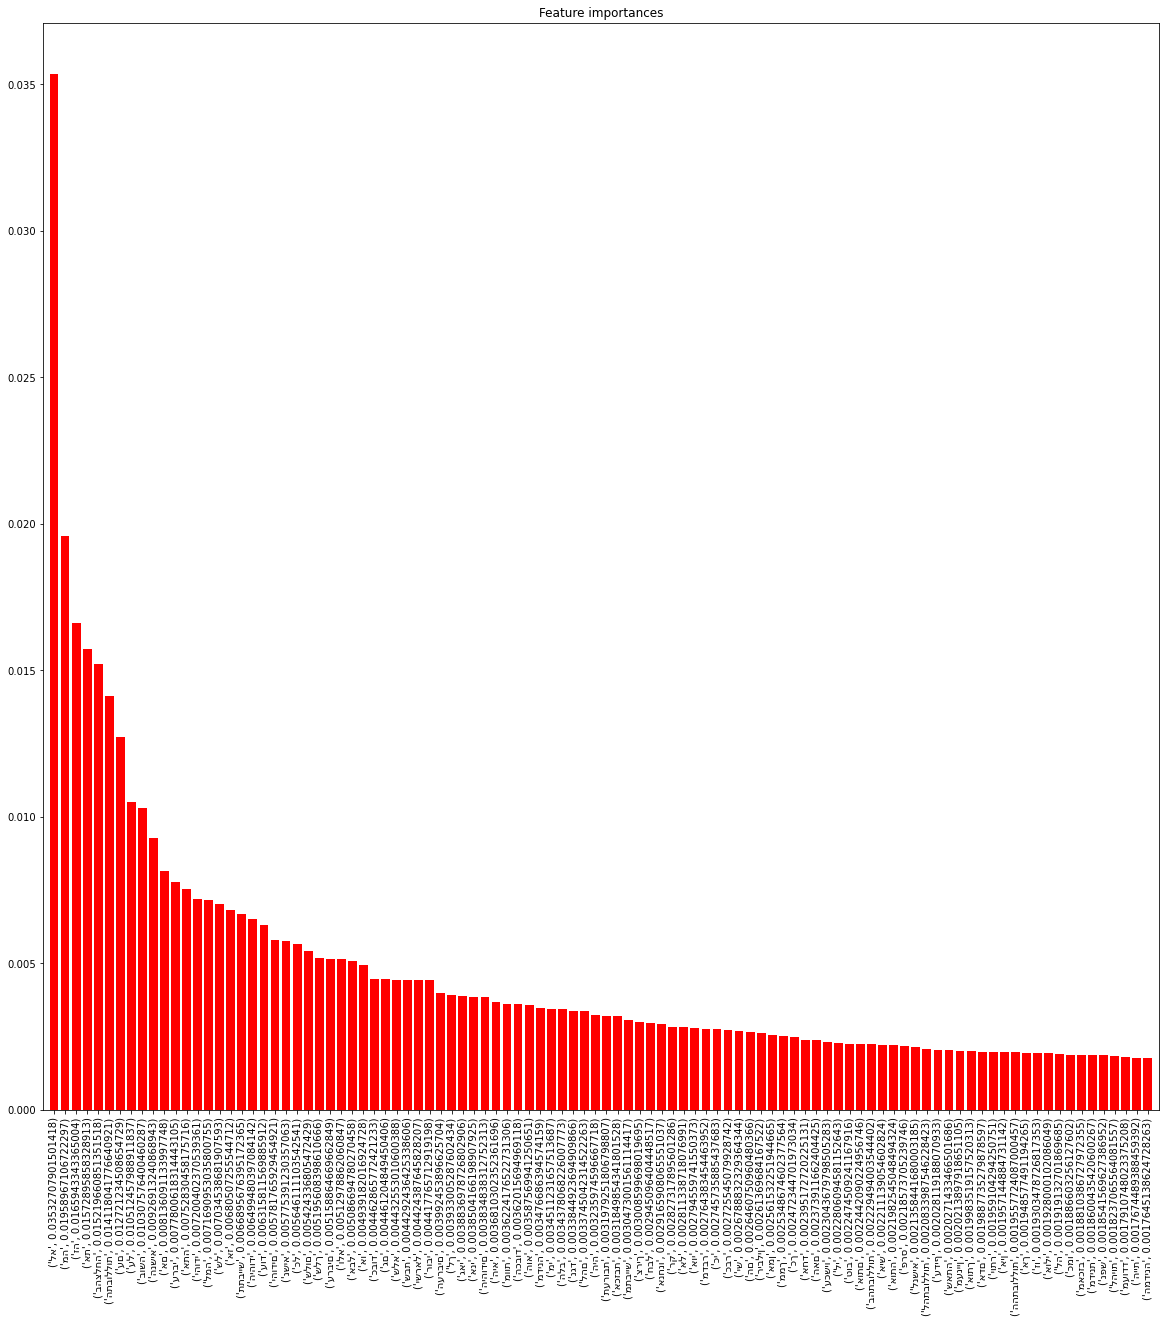

()

In [47]:
print_feature_importances(X_token_train, token_classifier, tfidf_token_converter)

Feature ranking:
feature 873 : ◊ú◊ê (0.039690)
feature 501 : ◊î◊™◊ë◊ï◊ú◊ú◊ï◊™ (0.025627)
feature 1118 : ◊û◊î (0.023774)
feature 488 : ◊î◊¶◊ú◊ó◊î (0.023037)
feature 513 : ◊ñ◊î (0.018891)
feature 193 : ◊ê◊™ (0.016008)
feature 1446 : ◊†◊©◊ô◊ê (0.014583)
feature 692 : ◊ô◊î◊ï◊ì◊ô (0.013583)
feature 1568 : ◊¢◊®◊ë◊ô◊ù (0.012707)
feature 448 : ◊î◊ô◊ê (0.011849)
feature 1536 : ◊¢◊ù (0.011661)
feature 696 : ◊ô◊î◊ï◊ì◊ô◊ù (0.010887)
feature 221 : ◊ë◊ï◊©◊î (0.010876)
feature 1563 : ◊¢◊®◊ë◊ô (0.010639)
feature 1526 : ◊¢◊ú (0.010148)
feature 470 : ◊î◊ù (0.010034)
feature 1834 : ◊©◊ú (0.009807)
feature 194 : ◊ê◊™◊î (0.009718)
feature 797 : ◊õ◊ë◊ï◊ì (0.009610)
feature 139 : ◊ê◊ù (0.007966)


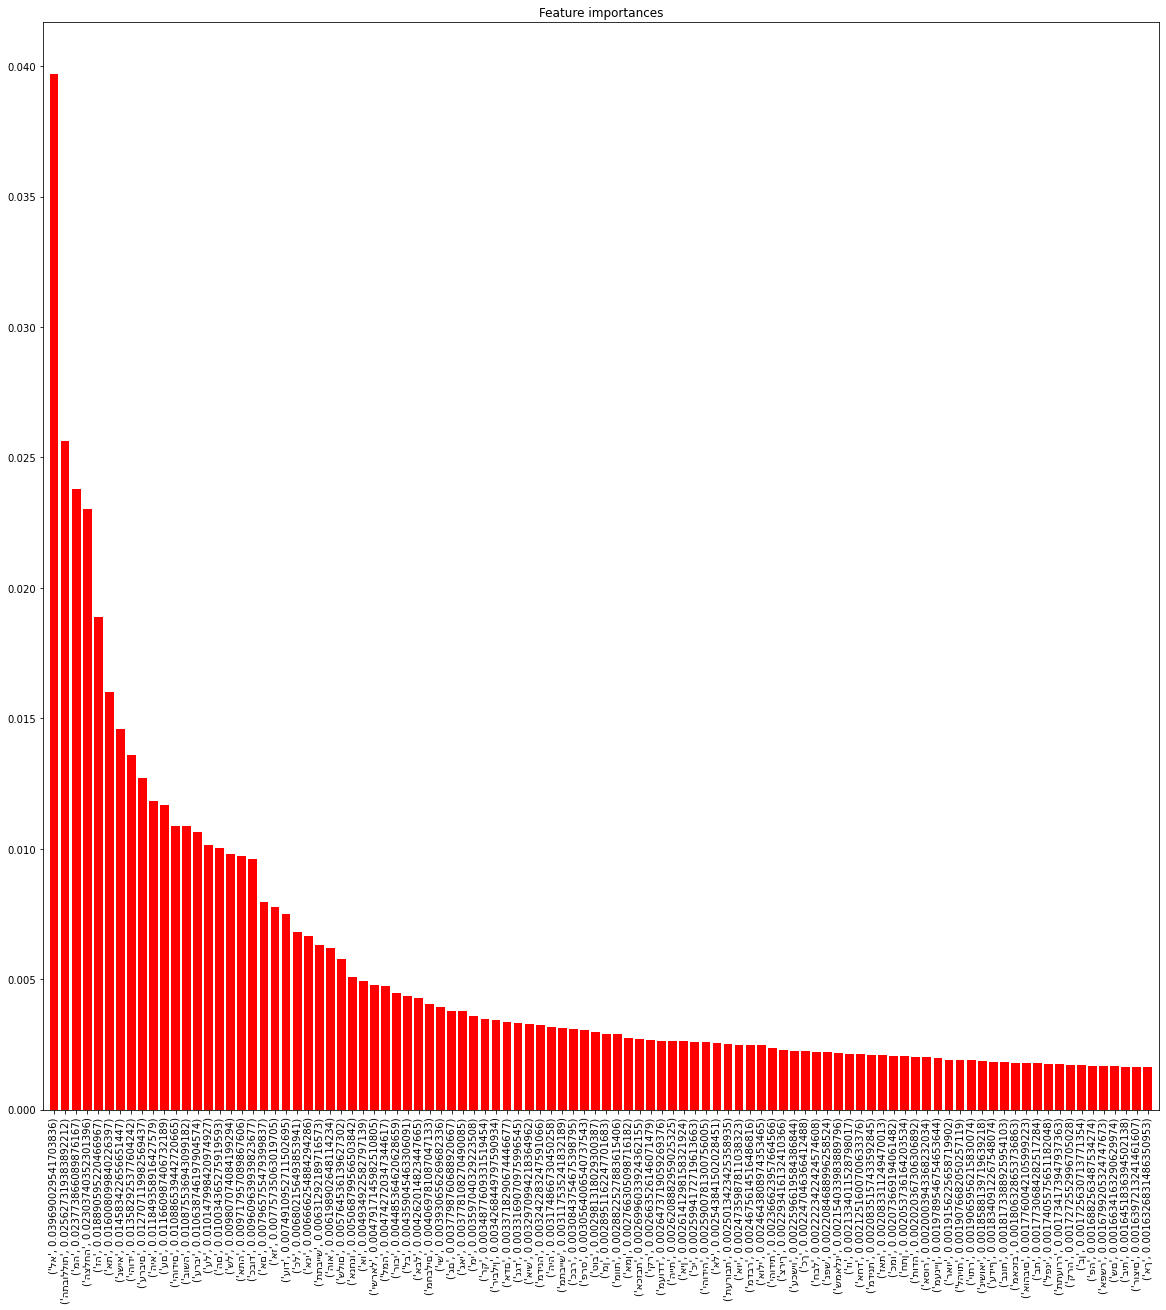

()

In [48]:
print_feature_importances(X_morph_train, morph_classifier, tfidf_morph_converter)

Feature ranking:
feature 1196 : not (0.030099)
feature 133 : assimilation (0.020836)
feature 926 : jewish (0.015166)
feature 483 : do (0.014542)
feature 113 : arab (0.013337)
feature 1571 : shame (0.012273)
feature 1761 : that (0.012223)
feature 1339 : president (0.012190)
feature 908 : is (0.012160)
feature 114 : arabs (0.011265)
feature 917 : it (0.010503)
feature 1800 : to (0.010372)
feature 1762 : the (0.010160)
feature 718 : good (0.009674)
feature 1916 : what (0.009429)
feature 93 : and (0.009337)
feature 124 : ashamed (0.008548)
feature 1987 : you (0.008449)
feature 867 : if (0.008165)
feature 1040 : luck (0.007710)


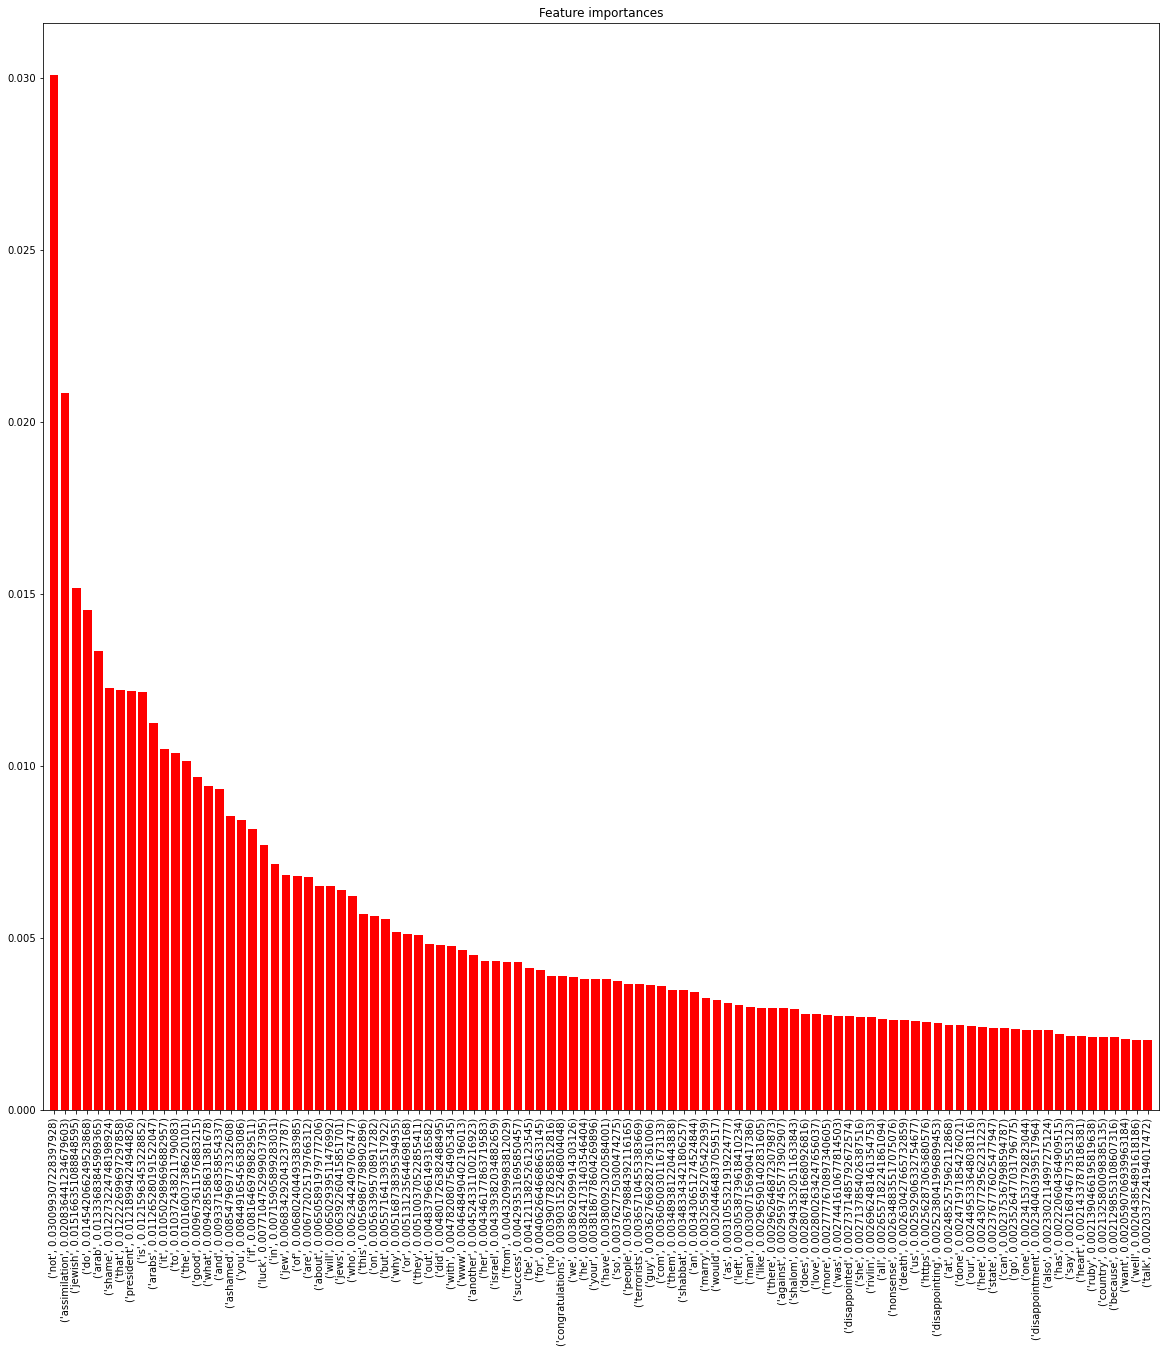

()

In [49]:
print_feature_importances(X_token_train_eng, token_eng_classifier, tfidf_token_eng_converter)

## SECOND MODEL
Using SVM classifier based on TD-IDF and POS Tagger
I will use only the english dataset, so i will be able to use nltk pos_tag

In [50]:
#process_eng_text_series function will get text Serier and clean it with regex expressions
def process_eng_text_series(series):

    for i,text in enumerate(series):  
        # Remove all the special characters
        text = re.sub(r'\W', ' ', str(text))

        # Remove all digits
        #processed_text = re.sub(r'\d+', ' ', processed_text)
        
        # remove all single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

        # Remove single characters from the start
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

        # Substituting multiple spaces with single space
        text= re.sub(r'\s+', ' ', text, flags=re.I)

        # Removing prefixed 'b'
        text = re.sub(r'^b\s+', '', text)

        # Converting to Lowercase
        text = text.lower()
        
        series[i] = text

In [51]:
#Put labels on the coloumns
token_train_eng = token_train_eng.rename(columns = {0: 'text', 1: 'label'}, inplace = False)
token_test_eng = token_test_eng.rename(columns = {0: 'text', 1: 'label'}, inplace = False)

In [52]:
#Clean dataset using process_eng_text_series function
process_eng_text_series(token_train_eng['text'])
process_eng_text_series(token_test_eng['text'])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
#word_tokenize will get text and return it tokenized in list
token_train_eng['text']= [word_tokenize(entry) for entry in token_train_eng['text']]
token_test_eng['text']= [word_tokenize(entry) for entry in token_test_eng['text']]

In [54]:
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [55]:
#data_lemmatization function will get dataset and lemmatize the text.
#lemmatization is the process of converting a word to its base form.
def data_lemmatization(data):
    for index,entry in enumerate(data['text']):
        Final_words = []
        word_Lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)

        data.loc[index,'text_final'] = str(Final_words)

In [56]:
data_lemmatization(token_train_eng)

In [57]:
data_lemmatization(token_test_eng)

In [58]:
#Seperate the text and the sentiment labels
token_train_eng_X = token_train_eng['text_final']
token_train_eng_Y = token_train_eng['label']
token_test_eng_X = token_test_eng['text_final']
token_test_eng_Y = token_test_eng['label']

In [59]:
token_train_eng_Y = token_train_eng_Y.values
token_test_eng_Y = token_test_eng_Y.values

In [60]:
#Create feature vectors containing TF-IDF values
Tfidf_vect_eng = TfidfVectorizer(max_features=2000)
Tfidf_vect_eng.fit(token_train_eng['text_final'])
token_train_eng_X_Tfidf = Tfidf_vect_eng.transform(token_train_eng_X)
token_test_eng_X_Tfidf = Tfidf_vect_eng.transform(token_test_eng_X)

## Build Classifier
I will use SVM to classify the data

In [61]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(token_train_eng_X_Tfidf,token_train_eng_Y)

predictions_SVM = SVM.predict(token_test_eng_X_Tfidf)

print("token_eng model")
print(confusion_matrix(token_test_eng_Y, predictions_SVM))  
print(classification_report(token_test_eng_Y, predictions_SVM))  
print(accuracy_score(token_test_eng_Y, predictions_SVM))

token_eng model
[[1592   98    8]
 [ 159  625    6]
 [  28   21   23]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1698
           1       0.84      0.79      0.81       790
           2       0.62      0.32      0.42        72

    accuracy                           0.88      2560
   macro avg       0.79      0.68      0.72      2560
weighted avg       0.87      0.88      0.87      2560

0.875


## With the Random Forest Classifier (FIRST MODEL) i achieved better results than the SVM classfier.